# Portfolios

In this notebook we create and evaluate investment portfolios. Saved results can be evaluated in evaluate.ipynb.

In [ ]:
import pandas as pd
from ratios import process_tickers
from setup import stocks

# If df_results.csv has not yet been made, otherwise, you can skip this step
results, error_tickers = process_tickers(pd.DataFrame(stocks))
df_results = pd.DataFrame(results)

/Users/adene/Documents/School/Carroll_2024-25/SeniorProject-PortfolioManagement/src/ratios.py:136: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  market_price_per_share = stock.adj_close[-1]
/Users/adene/Documents/School/Carroll_2024-25/SeniorProject-PortfolioManagement/src/ratios.py:136: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  market_price_per_share = stock.adj_close[-1]
/Users/adene/Documents/School/Carroll_2024-25/SeniorProject-PortfolioManagement/src/ratios.py:136: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (c

Processing MSFT... Success in 10.06 sec
Processing NVDA... Success in 10.17 sec


/Users/adene/Documents/School/Carroll_2024-25/SeniorProject-PortfolioManagement/src/ratios.py:136: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  market_price_per_share = stock.adj_close[-1]
/Users/adene/Documents/School/Carroll_2024-25/SeniorProject-PortfolioManagement/src/ratios.py:136: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  market_price_per_share = stock.adj_close[-1]
/Users/adene/Documents/School/Carroll_2024-25/SeniorProject-PortfolioManagement/src/ratios.py:136: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (c

Processing AAPL... Success in 10.36 sec


Processing MRNA... Success in 10.66 sec
Processing INTC... Success in 11.51 sec


/Users/adene/Documents/School/Carroll_2024-25/SeniorProject-PortfolioManagement/src/ratios.py:136: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  market_price_per_share = stock.adj_close[-1]


Processing IBM... Success in 13.82 sec
Processing JNJ... Success in 13.92 sec
Processing PFE... Success in 14.16 sec


Processing ABBV... Success in 14.52 sec


Processing UNH... Success in 15.34 sec


/Users/adene/Documents/School/Carroll_2024-25/SeniorProject-PortfolioManagement/src/ratios.py:136: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  market_price_per_share = stock.adj_close[-1]
/Users/adene/Documents/School/Carroll_2024-25/SeniorProject-PortfolioManagement/src/ratios.py:136: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  market_price_per_share = stock.adj_close[-1]
/Users/adene/Documents/School/Carroll_2024-25/SeniorProject-PortfolioManagement/src/ratios.py:136: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (c

Processing GS... Success in 7.47 sec


Processing JPM... Success in 7.97 sec
Processing BAC... Success in 7.99 sec


/Users/adene/Documents/School/Carroll_2024-25/SeniorProject-PortfolioManagement/src/ratios.py:136: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  market_price_per_share = stock.adj_close[-1]
/Users/adene/Documents/School/Carroll_2024-25/SeniorProject-PortfolioManagement/src/ratios.py:136: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  market_price_per_share = stock.adj_close[-1]
/Users/adene/Documents/School/Carroll_2024-25/SeniorProject-PortfolioManagement/src/ratios.py:136: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (c

Processing WFC... Success in 8.97 sec


Processing C... Success in 8.62 sec
Processing HD... Success in 6.45 sec


/Users/adene/Documents/School/Carroll_2024-25/SeniorProject-PortfolioManagement/src/ratios.py:136: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  market_price_per_share = stock.adj_close[-1]


Processing TSLA... Success in 6.26 sec


/Users/adene/Documents/School/Carroll_2024-25/SeniorProject-PortfolioManagement/src/ratios.py:136: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  market_price_per_share = stock.adj_close[-1]


Processing AMZN... Success in 6.86 sec


Processing MCD... Success in 8.43 sec
Processing NKE... Success in 7.21 sec


/Users/adene/Documents/School/Carroll_2024-25/SeniorProject-PortfolioManagement/src/ratios.py:136: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  market_price_per_share = stock.adj_close[-1]
/Users/adene/Documents/School/Carroll_2024-25/SeniorProject-PortfolioManagement/src/ratios.py:136: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  market_price_per_share = stock.adj_close[-1]
/Users/adene/Documents/School/Carroll_2024-25/SeniorProject-PortfolioManagement/src/ratios.py:136: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (c

Processing WMT... Success in 5.82 sec
Processing PG... Success in 6.47 sec
Processing KO... Success in 6.35 sec


/Users/adene/Documents/School/Carroll_2024-25/SeniorProject-PortfolioManagement/src/ratios.py:136: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  market_price_per_share = stock.adj_close[-1]
/Users/adene/Documents/School/Carroll_2024-25/SeniorProject-PortfolioManagement/src/ratios.py:136: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  market_price_per_share = stock.adj_close[-1]
/Users/adene/Documents/School/Carroll_2024-25/SeniorProject-PortfolioManagement/src/ratios.py:136: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (c

Processing COST... Success in 6.01 sec


/Users/adene/Documents/School/Carroll_2024-25/SeniorProject-PortfolioManagement/src/ratios.py:136: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  market_price_per_share = stock.adj_close[-1]


Processing PEP... Success in 6.01 sec
Processing XOM... Success in 6.38 sec


/Users/adene/Documents/School/Carroll_2024-25/SeniorProject-PortfolioManagement/src/ratios.py:136: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  market_price_per_share = stock.adj_close[-1]
/Users/adene/Documents/School/Carroll_2024-25/SeniorProject-PortfolioManagement/src/ratios.py:136: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  market_price_per_share = stock.adj_close[-1]


Processing CVX... Success in 6.76 sec


/Users/adene/Documents/School/Carroll_2024-25/SeniorProject-PortfolioManagement/src/ratios.py:136: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  market_price_per_share = stock.adj_close[-1]


Processing SLB... Success in 6.92 sec
Processing EOG... Success in 6.27 sec


/Users/adene/Documents/School/Carroll_2024-25/SeniorProject-PortfolioManagement/src/ratios.py:136: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  market_price_per_share = stock.adj_close[-1]
/Users/adene/Documents/School/Carroll_2024-25/SeniorProject-PortfolioManagement/src/ratios.py:136: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  market_price_per_share = stock.adj_close[-1]


Processing OXY... Success in 6.67 sec


/Users/adene/Documents/School/Carroll_2024-25/SeniorProject-PortfolioManagement/src/ratios.py:136: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  market_price_per_share = stock.adj_close[-1]
/Users/adene/Documents/School/Carroll_2024-25/SeniorProject-PortfolioManagement/src/ratios.py:136: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  market_price_per_share = stock.adj_close[-1]


Processing CAT... Success in 6.60 sec


/Users/adene/Documents/School/Carroll_2024-25/SeniorProject-PortfolioManagement/src/ratios.py:136: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  market_price_per_share = stock.adj_close[-1]


Processing DE... Success in 6.89 sec


/Users/adene/Documents/School/Carroll_2024-25/SeniorProject-PortfolioManagement/src/ratios.py:136: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  market_price_per_share = stock.adj_close[-1]


Processing BA... Success in 7.68 sec


/Users/adene/Documents/School/Carroll_2024-25/SeniorProject-PortfolioManagement/src/ratios.py:136: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  market_price_per_share = stock.adj_close[-1]
/Users/adene/Documents/School/Carroll_2024-25/SeniorProject-PortfolioManagement/src/ratios.py:136: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  market_price_per_share = stock.adj_close[-1]


Processing HON... Success in 7.91 sec


/Users/adene/Documents/School/Carroll_2024-25/SeniorProject-PortfolioManagement/src/ratios.py:136: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  market_price_per_share = stock.adj_close[-1]


Processing DUK... Success in 8.42 sec


/Users/adene/Documents/School/Carroll_2024-25/SeniorProject-PortfolioManagement/src/ratios.py:136: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  market_price_per_share = stock.adj_close[-1]


Processing SO... Success in 8.25 sec
Processing DOW... Success in 7.70 sec
Processing AEP... Success in 9.31 sec


/Users/adene/Documents/School/Carroll_2024-25/SeniorProject-PortfolioManagement/src/ratios.py:136: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  market_price_per_share = stock.adj_close[-1]


Processing EXC... Success in 9.57 sec
Processing FCX... Success in 8.82 sec


/Users/adene/Documents/School/Carroll_2024-25/SeniorProject-PortfolioManagement/src/ratios.py:136: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  market_price_per_share = stock.adj_close[-1]
/Users/adene/Documents/School/Carroll_2024-25/SeniorProject-PortfolioManagement/src/ratios.py:136: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  market_price_per_share = stock.adj_close[-1]


Processing LIN... Success in 9.36 sec


/Users/adene/Documents/School/Carroll_2024-25/SeniorProject-PortfolioManagement/src/ratios.py:136: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  market_price_per_share = stock.adj_close[-1]


Processing NEM... Success in 9.76 sec


/Users/adene/Documents/School/Carroll_2024-25/SeniorProject-PortfolioManagement/src/ratios.py:136: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  market_price_per_share = stock.adj_close[-1]


Processing DIS... Success in 9.60 sec
Processing NFLX... Success in 8.20 sec


/Users/adene/Documents/School/Carroll_2024-25/SeniorProject-PortfolioManagement/src/ratios.py:136: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  market_price_per_share = stock.adj_close[-1]
/Users/adene/Documents/School/Carroll_2024-25/SeniorProject-PortfolioManagement/src/ratios.py:136: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  market_price_per_share = stock.adj_close[-1]
/Users/adene/Documents/School/Carroll_2024-25/SeniorProject-PortfolioManagement/src/ratios.py:136: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (c

Processing T... Success in 8.06 sec
Processing VZ... Success in 8.06 sec
Processing PLD... Success in 6.89 sec
Processing O... Success in 7.20 sec


/Users/adene/Documents/School/Carroll_2024-25/SeniorProject-PortfolioManagement/src/ratios.py:136: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  market_price_per_share = stock.adj_close[-1]
/Users/adene/Documents/School/Carroll_2024-25/SeniorProject-PortfolioManagement/src/ratios.py:136: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  market_price_per_share = stock.adj_close[-1]


Processing SPG... Success in 6.64 sec
Processing AMT... Success in 6.59 sec


df_encoded ready: shape (46, 96)
PCA complete: projected data shape (46, 2)


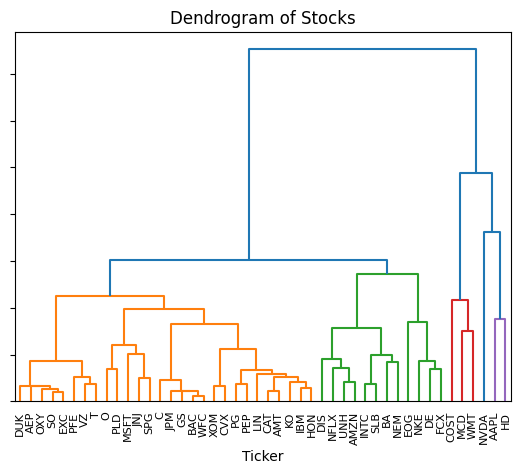

In [ ]:
import pandas as pd
import setup

df_results = pd.read_csv("df_results.csv")

# If the risk column has not yet been created, create it.
if "risk" not in df_results.columns:
    df_results["risk"] = setup.compute_risk(df_results)
    df_results.to_csv("df_results.csv", index=False)

# Remove stocks with insufficient historical data for backtesting
df_results = df_results[~df_results["ticker"].isin(["DOW", "MRNA", "ABBV", "TSLA"])]

df_results = setup.compute_composite_metrics(df_results)
df_encoded = setup.setup_data(df_results)

pca_cols = ["profitability", "liquidity", "efficiency", "market_value", "leverage"]
projectedData, pca_model = setup.perform_pca(df_encoded, columns=pca_cols, n_components=2)

# df_results[pca_cols]
df_results = setup.compute_clusters(df_results, df_results[pca_cols], method="dendrogram", n_clusters=5)

In [5]:
df_results[["ticker"] + pca_cols]

,ticker,profitability,liquidity,efficiency,market_value,leverage
0,AAPL,1.976935,-0.341527,2.105240,2.197644,1.027773
1,MSFT,1.883232,1.201107,0.143427,1.331835,0.390123
2,NVDA,0.529821,3.749290,-0.102903,7.434488,-0.568840
3,PFE,-0.532759,-0.893948,-0.813460,-1.553356,-0.578217
4,UNH,-0.652391,-0.383369,2.147648,0.547571,-0.213943
5,INTC,-0.937750,0.346536,-0.264063,-0.242634,-1.114061
6,JNJ,2.383433,0.244495,-0.384705,-0.212934,-0.079918
7,JPM,0.254943,0.073435,-0.997512,0.280667,1.288062
8,IBM,0.075856,-0.050418,0.276364,0.197164,0.419458
9,BAC,0.034755,0.073435,-1.012862,-0.215693,1.207879


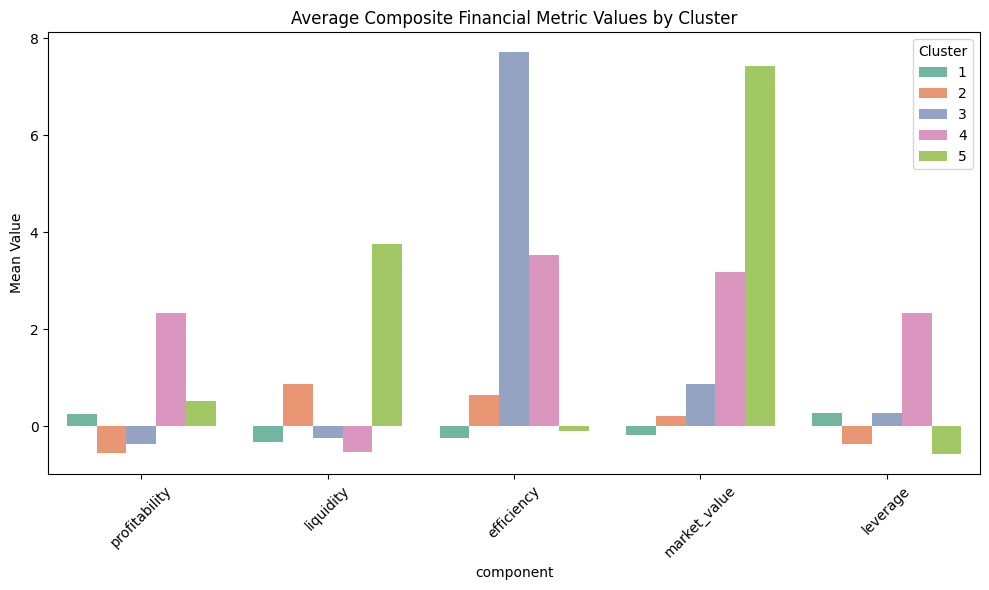

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate average PCA component values per cluster
cluster_means = df_results.groupby('cluster')[pca_cols].mean().round(2)

# Reshape for plotting
df_melted = cluster_means.reset_index().melt(id_vars='cluster', var_name='component', value_name='mean_value')

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=df_melted, x='component', y='mean_value', hue='cluster', palette='Set2')
plt.title('Average Composite Financial Metric Values by Cluster')
plt.ylabel('Mean Value')
plt.xticks(rotation=45)
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

In [10]:
df_results[df_results["cluster"] == 4]["ticker"]

0     AAPL
14      HD
Name: ticker, dtype: object

In [62]:
df_results["cluster"].value_counts()

cluster
1    28
2    12
3     3
4     2
5     1
Name: count, dtype: int64

In [2]:
df_results = setup.compute_clusters(df_results, projectedData, method="kmeans", n_clusters=3)

df_results[df_results["ticker"].isin(["AAPL", "MSFT"])][["ticker"] + pca_cols]

,ticker,profitability,liquidity,efficiency,market_value,leverage
0,AAPL,1.976935,-0.341527,2.105240,2.197644,1.027773
1,MSFT,1.883232,1.201107,0.143427,1.331835,0.390123


In [59]:
from sklearn.cluster import KMeans

df_PCA = pd.DataFrame(projectedData, columns=['prin_comp_1','prin_comp_2'])
model = KMeans(n_clusters = 5, random_state=42)
cluster_labels = model.fit_predict(df_PCA)

# Assign cluster labels
# df_results['cluster'] = cluster_labels
df_PCA['cluster'] = cluster_labels
df_PCA['cluster'] = df_PCA['cluster'].astype(str)
df_PCA['ticker'] = df_results['ticker']

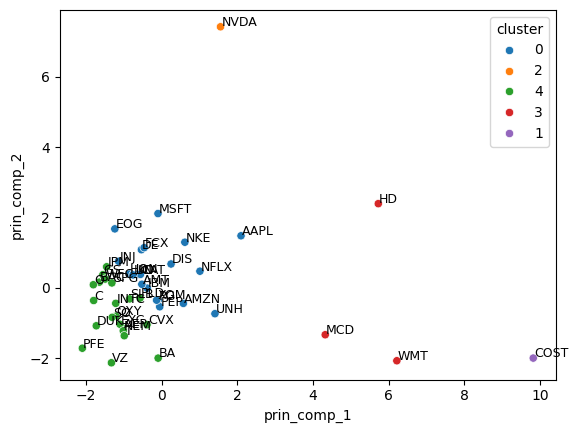

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(data=df_PCA, x='prin_comp_1', y='prin_comp_2', hue='cluster')

# Add labels to each point
for i, row in df_PCA.iterrows():
    plt.text(row['prin_comp_1'] + 0.02,  # small offset to avoid overlap
             row['prin_comp_2'] + 0.02,
             str(row['ticker']),   # replace with your actual label column
             fontsize=9)

plt.show()

### Check Earliest Stock Dates

In [ ]:
import okama as ok
from tqdm import tqdm

all_assets = ok.AssetList([ticker + ".US" for ticker in df_results["ticker"]])

earliest = {}
for ticker in all_assets:
    earliest[ticker] = ticker.first_date

100%|██████████| 46/46 [01:32<00:00,  2.01s/it]


In [8]:
df_results["earliest"] = df_results["ticker"].map(earliest)

In [35]:
df_results.sort_values(by = "earliest", inplace = True, ascending = False)
df_results[["ticker", "earliest"]].head()

,ticker,earliest
37,DOW,2019-04-01
2,MRNA,2019-01-01
1,ABBV,2013-01-01
16,TSLA,2010-07-01
42,NFLX,2002-06-01


### Check Historical Stock Volatility/Return

In [257]:
import okama as ok
all_assets = ok.AssetList([ticker + ".US" for ticker in df_results["ticker"]])

In [259]:
pf = ok.Portfolio(
    assets=all_assets,
    weights=[1 / len(all_assets)] * len(all_assets),    
    ccy='USD',
    rebalancing_period='month',  # 'Q' for quarterly, 'A' for annual, etc.
    first_date='2004-01',    # pick a reasonable start date (earliest is 2003-09 from initial assessment)
    last_date='2024-02'       # pick an end date to evaluate
)

In [ ]:
pf.monte_carlo_returns_ts

In [9]:
# Calculate the rolling annual risk for each asset
rolling_risks = all_assets.get_rolling_risk_annual()

risks = {}

# Calculate the average rolling risk for each asset
for asset in all_assets:
    risks[asset.ticker] = rolling_risks[asset.ticker + ".US"][0]

# Map the calculated risks to the "ticker" column in df_results
df_results["risk"] = df_results["ticker"].map(risks)

/var/folders/rs/dqcm8rm967g9vzgwrpdplf080000gn/T/ipykernel_93025/365516123.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  risks[asset.ticker] = rolling_risks[asset.ticker + ".US"][0]


In [ ]:
# # Write to CSV
# df_results.to_csv("df_results.csv", index=False)

#### AMT and Risk Exploration Sidebar

In [52]:
stock = ok.Asset("AMT.US")

In [ ]:
# Explore this weird result
df_results.sort_values(by = "risk", inplace = True, ascending = False)
df_results[["ticker", "risk"]].head()

,ticker,risk
48,AMT,20.437652
4,NVDA,3.059320
18,AMZN,1.085627
42,NFLX,0.957420
9,JPM,0.678396


[(0.0, 1.5)]

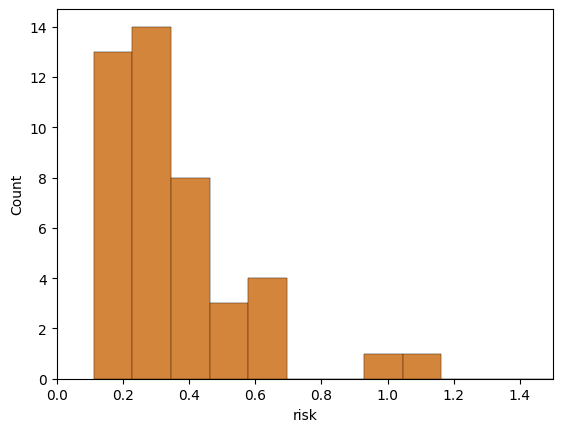

In [ ]:
import seaborn as sns

sns.histplot(df_results["risk"]).set(xlim=(0, 1.5))

<Axes: xlabel='risk', ylabel='Count'>

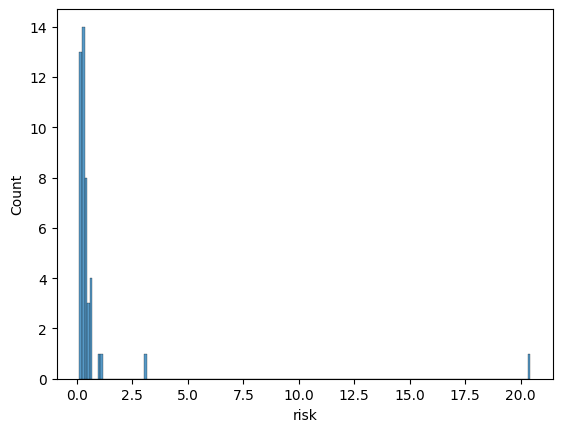

In [64]:
sns.histplot(df_results["risk"])

##

## Evaluate Models 

### Setup Portfolio and Evaluation Function

In [ ]:
# DONT USE THIS, IT DOES NOT WORK
def update_weights(tickers, pf):
    tickers_with_ext = [f"{ticker}.US" for ticker in tickers]
    weight = 1/len(tickers)
    for i, key in enumerate(pf.assets_weights.keys()):
        pf.assets_weights[key] = 0
        pf.weights[i] = 0
        if key in tickers_with_ext:
            pf.assets_weights[key] = weight   
            pf.weights[i] = weight 

In [6]:
import pandas as pd

def ticker_policy(df_results, policy="Industry", sample_size=15, random_state=42):
    match policy:
        case "Random":
            return df_results.sample(sample_size, random_state=random_state)["ticker"]
        
        case "Industry":
            # Standardize industry_grouped_portfolio
            industry_counts = df_results['Industry'].value_counts()
            selected_industries = industry_counts.sample(min(11, sample_size), random_state=random_state).index.tolist()
            industry_grouped_portfolio = df_results[df_results['Industry'].isin(selected_industries)].groupby('Industry').apply(
                lambda x: x.sample(1, random_state=random_state)
            ).reset_index(drop=True)

            # Add additional stocks from industries with more stocks
            additional_industries = industry_counts[~industry_counts.index.isin(selected_industries)].sample(max(0, sample_size - 11), random_state=random_state).index.tolist()
            additional_stocks = df_results[df_results['Industry'].isin(additional_industries)].groupby('Industry').apply(
                lambda x: x.sample(1, random_state=random_state)
            ).reset_index(drop=True)

            industry_grouped_portfolio = pd.concat([industry_grouped_portfolio, additional_stocks]).reset_index(drop=True)
            return industry_grouped_portfolio["ticker"]
        
        case "Base":
            # Standardize base_portfolio
            base_portfolio = df_results.groupby('cluster').apply(
                lambda x: x.sample(min(len(x), 3), random_state=random_state)
            ).reset_index(drop=True)

            # If fewer than sample_size stocks, sample additional stocks from other clusters
            if len(base_portfolio) < sample_size:
                additional_stocks = df_results[~df_results['ticker'].isin(base_portfolio['ticker'])].sample(
                    sample_size - len(base_portfolio), random_state=random_state
                )
                base_portfolio = pd.concat([base_portfolio, additional_stocks]).reset_index(drop=True)

            return base_portfolio["ticker"]
        
        case "Base-High":
            base_high = df_results.groupby('cluster').apply(
                lambda x: x.nlargest(3, 'risk')
            ).reset_index(drop=True)

            if len(base_high) < sample_size:
                additional_stocks = df_results[~df_results['ticker'].isin(base_high['ticker'])].nlargest(
                    sample_size - len(base_high), 'risk'
                )
                base_high = pd.concat([base_high, additional_stocks]).reset_index(drop=True)

            return base_high["ticker"]

        case "Base-Low":
            base_low = df_results.groupby('cluster').apply(
                lambda x: x.nsmallest(3, 'risk')
            ).reset_index(drop=True)

            if len(base_low) < sample_size:
                additional_stocks = df_results[~df_results['ticker'].isin(base_low['ticker'])].nsmallest(
                    sample_size - len(base_low), 'risk'
                )
                base_low = pd.concat([base_low, additional_stocks]).reset_index(drop=True)

            return base_low["ticker"]

        
        case "LowRisk":
            # Standardize low-risk portfolio
            low_risk_portfolio = df_results[df_results["risk"] < df_results["risk"].quantile(0.33)].sample(sample_size, random_state=random_state)
            return low_risk_portfolio["ticker"]
        
        case "MediumRisk":
            # Standardize medium-risk portfolio
            med_df = df_results[
                (df_results["risk"] >= df_results["risk"].quantile(0.34)) & 
                (df_results["risk"] < df_results["risk"].quantile(0.66))
            ]
            med_risk_portfolio = med_df.sample(min(sample_size, len(med_df)), random_state=random_state)
            return med_risk_portfolio["ticker"]
        
        case "HighRisk":
            # Standardize high-risk portfolio
            high_risk_portfolio = df_results[df_results["risk"] >= df_results["risk"].quantile(0.67)].sample(sample_size, random_state=random_state)
            return high_risk_portfolio["ticker"]
        
        case _:
            raise ValueError(f"Unknown policy: {policy}")

# Example usage:
# tickers = ticker_policy(df_results, policy="Industry", sample_size=15, random_state=42)

In [5]:
def extract_return(wealth_index, start_date, end_date):
    # Overall return
    start_val = wealth_index.loc[start_date, wealth_index.columns[0]]
    end_val   = wealth_index.loc[end_date, wealth_index.columns[0]]
    overall = end_val / start_val - 1
    
    # Annualized return
    sd = pd.to_datetime(start_date)
    ed = pd.to_datetime(end_date)
    years = (ed - sd).days / 365.25
    annual = (end_val / start_val) ** (1/years) - 1
    
    # Year-on-year returns
    yoy = {}
    for year in range(int(start_date[:4]), int(end_date[:4])):
        d1 = f"{year}-12"
        d2 = f"{year+1}-12"
        try:
            ret = wealth_index.loc[d2, wealth_index.columns[0]] / wealth_index.loc[d1, wealth_index.columns[0]] - 1
        except Exception:
            ret = None
        yoy[f"{year}-{year+1}"] = ret
    return overall, annual, yoy

start_date = "2021-12"
end_date   = "2024-02"

overall_ret, ann_ret, yoy_returns = extract_return(pf.wealth_index, start_date, end_date)

print(f"Period: {start_date} to {end_date}")
print(f"Overall Return: {overall_ret * 100:.2f}%")
print(f"Annualized Return: {ann_ret * 100:.2f}%")
print("Year-on-Year Returns:", yoy_returns)

NameError: name 'pf' is not defined

In [16]:
import okama as ok

# tickers = list(base_portfolio["ticker"])
# tickers = list(low_risk_portfolio["ticker"])
# tickers = list(med_risk_portfolio["ticker"])
# tickers = list(high_risk_portfolio["ticker"])
# tickers = list(random_portfolio)
# tickers = list(df_results["ticker"]) # All tickers

tickers = ticker_policy(df_results, "Random", sample_size=15, random_state=42)

tickers_with_ext = [f"{ticker}.US" for ticker in tickers]


assets = tickers_with_ext
weights = [1/len(tickers)] * len(tickers)

pf = ok.Portfolio(
    assets=assets,
    weights=weights,    
    ccy='USD',
    rebalancing_period='month',  # 'Q' for quarterly, 'A' for annual, etc.
    first_date='2004-01',    # pick a reasonable start date (earliest is 2003-09 from initial assessment)
    last_date='2024-02'       # pick an end date to evaluate
)

### Bootstrapped Sample of Years

In [17]:
NUMBER_OF_BOOTSTRAPPED_SAMPLES = 500
YEARS_OF_SAMPLE = 5

results = []

for i in range(NUMBER_OF_BOOTSTRAPPED_SAMPLES):
    # Randomly select a 12 month period in the range 2004-01 to 2023-01
    END_DATE = 2023 # 
    DATE_RANGE_END = END_DATE - YEARS_OF_SAMPLE
    start_date = f"{np.random.randint(2004, DATE_RANGE_END):04d}-{np.random.randint(1, 13):02d}"
    end_date   = f"{int(start_date[:4])+YEARS_OF_SAMPLE:04d}-{start_date[5:]}"

    overall_ret, ann_ret, yoy_returns = extract_return(pf.wealth_index, start_date, end_date)
    
    # Store results
    results.append({
        "start_date": start_date,
        "end_date": end_date,
        "start_value": pf.wealth_index.loc[start_date, pf.wealth_index.columns[0]],
        "end_value": pf.wealth_index.loc[end_date, pf.wealth_index.columns[0]],
        "overall_ret": overall_ret,
        "ann_ret": ann_ret,
        "yoy_returns": yoy_returns
    })

res = results

In [16]:
from tools import save_portfolio_results, retrieve_portfolio_results

# save_portfolio_results(portfolio_name="random_portfolio", results=results, simulation="bootstrap")


In [18]:
res = retrieve_portfolio_results(portfolio_name="base_3m_5s_portfolio", simulation="bootstrap")

In [22]:
# Extract average end value
ovr_rets = res["overall_ret"]
print(f"Mean Return: {round(10000 * (1 + ovr_rets.mean()), 2):>15}")
print(f"Standard Deviation: {round(10000 * ovr_rets.std(), 2):>7}")

Mean Return:        24115.27
Standard Deviation: 5201.02


In [92]:
# Average annual returns
ann_rets = [result["ann_ret"] for result in res]
mean_ann_ret = np.mean(ann_rets)
std_ann_ret = np.std(ann_rets)

print(f"Average Yearly Return: {round(mean_ann_ret * 100, 2):>20}%", sep = "")
print("Standard Deviation of Yearly Returns: ", round(std_ann_ret * 100, 2), "%", sep = "")

Average Yearly Return:                13.18%
Standard Deviation of Yearly Returns: 3.22%


### Monte Carlo Simulation

In [ ]:
import okama as ok

# Options: random_portfolio, industry_grouped_portfolio, base_portfolio, low_risk_portfolio, med_risk_portfolio, high_risk_portfolio

# portfolio_choice = random_portfolio
# portfolio_choice = list(df_results["ticker"]) # All stocks
tickers = ticker_policy(df_results, policy="Random", sample_size=15, random_state=42)


tickers_with_ext = [f"{ticker}.US" for ticker in tickers]

assets = tickers_with_ext
weights = [1/len(assets)] * len(assets) # Equal weights

pf = ok.Portfolio(
    assets=assets,
    weights=weights,    
    ccy='USD',
    rebalancing_period='month',  # 'Q' for quarterly, 'A' for annual, etc.
    first_date='2004-01',    # pick a reasonable start date (earliest is 2003-09 from initial assessment)
    last_date='2024-02'       # pick an end date to evaluate
)

In [ ]:
import asyncio
import random
import pandas as pd
import okama as ok

# Number of simulations
num_simulations = 5

# List to store the results
returns_list = []

async def run_simulation(i):
    tickers = ticker_policy(df_results, "Random", sample_size=15, random_state=i)
    tickers_with_ext = [f"{ticker}.US" for ticker in tickers]
    assets = tickers_with_ext
    weights = [1/len(assets)] * len(assets)  # Equal weights
    
    pf = ok.Portfolio(
        assets=assets,
        weights=weights,    
        ccy='USD',
        rebalancing_period='month',  # 'Q' for quarterly, 'A' for annual, etc.
        first_date='2014-01',    # pick a reasonable start date (earliest is 2003-09 from initial assessment)
        last_date='2024-02'       # pick an end date to evaluate
    )
            
    # Run the Monte Carlo simulation with n=1
    wealth = pf.monte_carlo_wealth(distr='norm', years=5, n=1)
    
    # Take the last row as the 1 year return
    returns_y = wealth.iloc[-1, 0]
    
    return returns_y

async def main():
    tasks = [run_simulation(i) for i in range(num_simulations)]
    results = await asyncio.gather(*tasks)
    returns_series = pd.Series(results)
    return returns_series

# Run the main function and get the results
try:
    loop = asyncio.get_running_loop()
except RuntimeError:
    # No event loop is running, create a new one
    asyncio.run(main())
else:
    # An event loop is running, schedule the task
    loop.create_task(main())

In [ ]:
import random

# Number of simulations
num_simulations = 50

# List to store the results
returns_list = []

for i in range(num_simulations):
    
    tickers = ticker_policy(df_results, "Random", sample_size = 15, random_state = i)
    tickers_with_ext = [f"{ticker}.US" for ticker in tickers]
    assets = tickers_with_ext
    weights = [1/len(assets)] * len(assets) # Equal weights
    
    pf = ok.Portfolio(
        assets=assets,
        weights=weights,    
        ccy='USD',
        rebalancing_period='month',  # 'Q' for quarterly, 'A' for annual, etc.
        first_date='2014-01',    # pick a reasonable start date (earliest is 2003-09 from initial assessment)
        last_date='2024-02'       # pick an end date to evaluate
    )
            
    # Run the Monte Carlo simulation with n=1
    wealth = pf.monte_carlo_wealth(distr='norm', years=5, n=1)
    
    # Take the last row as the 1 year return
    returns_y = wealth.iloc[-1, 0]
    
    # Store the result
    returns_list.append(returns_y)

returns_series = pd.Series(returns_list)
returns = returns_series

  2%|▏         | 1/50 [00:28<23:20, 28.59s/it]


KeyboardInterrupt: 

In [ ]:
# import tools
from tools import save_portfolio_results, retrieve_portfolio_results

# save_portfolio_results(portfolio_name="random_portfolio", results=returns_series, simulation="monte_carlo")
returns = retrieve_portfolio_results("base_3m_5s_portfolio", simulation="monte_carlo")

In [ ]:
from tools import retrieve_portfolio_results

# load Monte Carlo results (series of final wealth values)
returns = retrieve_portfolio_results("base_3m_5s_portfolio", simulation="monte_carlo")

# raw stats
print("Average end value: $", round(returns.mean(), 2), sep="")
print("Std of end value: $", round(returns.std(), 2), sep="")

# compute annualized returns
initial_value = 10000
sim_length_months = 3    # e.g. '3m' => 3 months
years = sim_length_months / 12
annualized = (returns / initial_value) ** (1/years) - 1

print(f"Average annualized return: {annualized.mean() * 100:.2f}%")
print(f"Std annualized return: {annualized.std() * 100:.2f}%")

Average end value: $10587.0
Standard Deviation: $954.32


<Axes: xlabel='2029-01', ylabel='Count'>

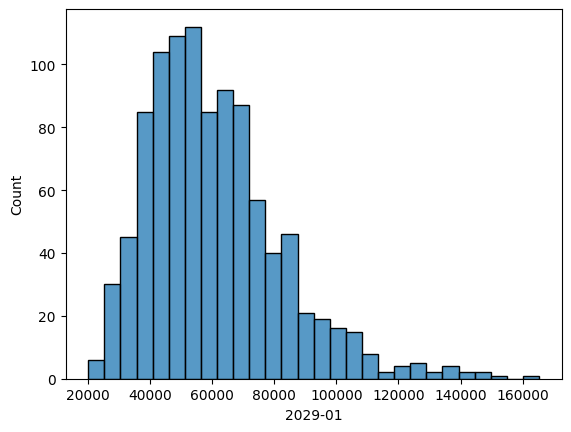

In [147]:
sns.histplot(returns_y)

### Scenario Analysis

In [73]:
import pandas as pd

# Define the contingency periods in a dictionary: (start_date, end_date)
contingencies = {
    "Housing Bust": ("2007-12", "2009-03"),
    "Covid Bust": ("2020-01", "2020-04"),
    "Decade Boom": ("2009-03", "2019-12"),
    "Covid Boom": ("2020-04", "2024-02"),
    "Two Decades": ("2004-02", "2024-02")
}

# Loop through each contingency, calculate returns, and store in a list of dictionaries
results = []
for label, (start_date, end_date) in contingencies.items():
    overall, annual, _ = extract_return(pf.wealth_index, start_date, end_date)
    results.append({
        "Contingency": label,
        "Period": f"{start_date} to {end_date}",
        "Overall Return (%)": round(overall * 100, 1),
        "Annual Return (%)": round(annual * 100, 1)
    })

# Create a DataFrame and nicely display it
df_returns = pd.DataFrame(results).set_index("Contingency")
display(df_returns)

,Period,Overall Return (%),Annual Return (%)
Contingency,,,
Housing Bust,2007-12 to 2009-03,-40.6,-34.1
Covid Bust,2020-01 to 2020-04,-14.1,-45.7
Decade Boom,2009-03 to 2019-12,808.3,22.8
Covid Boom,2020-04 to 2024-02,222.0,35.6
Two Decades,2004-02 to 2024-02,2695.7,18.1


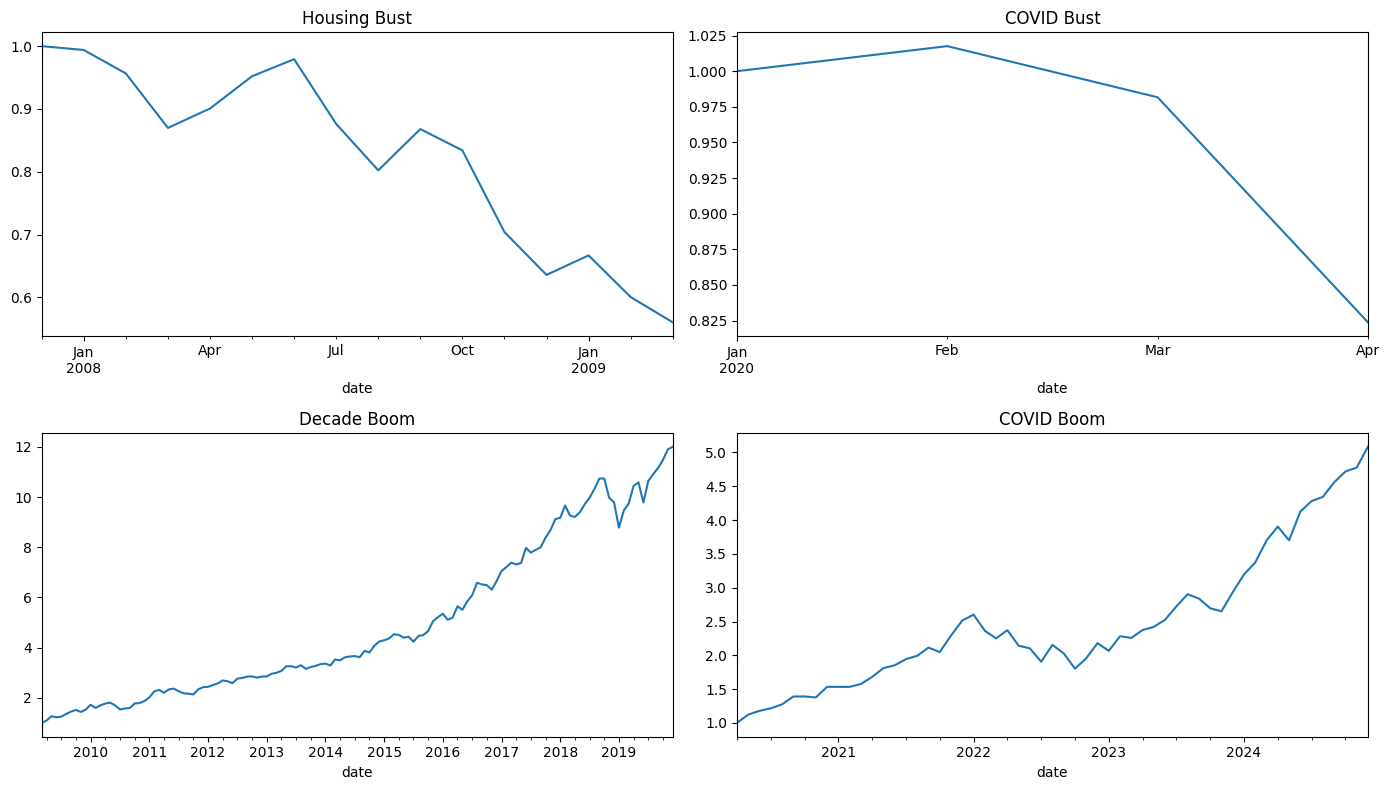

In [52]:
import matplotlib.pyplot as plt

contingencies = {
    "Housing Bust": ("2007-12", "2009-03"),
    "COVID Bust": ("2020-01", "2020-04"),
    "Decade Boom": ("2009-03", "2019-12"),
    "COVID Boom": ("2020-04", "2024-12")
}

fig, axes = plt.subplots(2, 2, figsize=(14, 8))
axes = axes.flatten()  # Easier indexing of axes

for ax, (name, (start, end)) in zip(axes, contingencies.items()):
    wealth_index = pf.wealth_index[pf.wealth_index.columns[0]] / pf.wealth_index.loc[start, pf.wealth_index.columns[0]]
    wealth_period = wealth_index.loc[start:end]

    wealth_period.plot(ax=ax, title=name, xlim=[start, end])

    # Dynamically adjust ylim
    data_min, data_max = wealth_period.min(), wealth_period.max()
    padding = (data_max - data_min) * 0.05
    ax.set_ylim(data_min - padding, data_max + padding)

plt.tight_layout()
plt.show()

### Recent Year Evaluation

In [10]:
import okama as ok

# tickers = list(df_results["ticker"])

tickers = list(base_portfolio["ticker"])

tickers_with_ext = [f"{ticker}.US" for ticker in tickers]


assets = tickers_with_ext
weights = [1/len(tickers)] * len(tickers)

pf = ok.Portfolio(
    assets=assets,
    weights=weights,    
    ccy='USD',
    rebalancing_period='month',  # 'Q' for quarterly, 'A' for annual, etc.
    first_date='2021-12',    # pick a reasonable start date (earliest is 2003-09 from initial assessment)
    last_date='2024-12'       # pick an end date to evaluate
)

In [11]:
def extract_return(wealth_index, start_date, end_date):
    return wealth_index.loc[end_date, wealth_index.columns[0]] / wealth_index.loc[start_date, wealth_index.columns[0]] - 1

start_date = "2021-12"
end_date = "2024-12"

ret = extract_return(pf.wealth_index, start_date, end_date)

print(f"Start date: {start_date}")
print(f"End date: {end_date}")
# print(f"Years: {end_date - start_date}")
print(f"Return: {ret * 100:.2f}%")
# Annualized return

# TODO: Show the year on year returns

Start date: 2021-12
End date: 2024-12
Return: 81.82%


## Formal Hypotheses Tests

In [6]:
# Setup code to run hypothesis test
import numpy as np
import pandas as pd
from scipy import stats

# Function to perform the hypothesis test (difference in means)

def hypothesis_test(mean1, std1, n1, mean2, std2, n2, alpha=0.05):
    # Calculate the t-statistic
    t_stat = (mean1 - mean2) / np.sqrt((std1**2 / n1) + (std2**2 / n2))
    
    # Calculate the degrees of freedom
    df = n1 + n2 - 2
    
    # Calculate the critical t-value
    t_critical = stats.t.ppf(1 - alpha/2, df)
    
    # Calculate the p-value
    p_value = 2 * (1 - stats.t.cdf(abs(t_stat), df))
    
    return t_stat, p_value, abs(t_stat) > t_critical

# Example
random_hb = (20597, 3313, 50)
industry_hb = (20412, 5366, 50)
random_mc = (36450, 17823, 50)
industry_mc = (50958, 41612, 50)

mean1, std1, n1 = random_mc
mean2, std2, n2 = industry_mc

alpha = 0.05 / 2 # Two-sided
t_stat, p_value, reject_null = hypothesis_test(mean1, std1, n1, mean2, std2, n2, alpha)

print(f"t-statistic: {t_stat}")
print(f"p-value: {p_value}")
print(f"Reject null hypothesis: {reject_null}")

t-statistic: -2.266201285358999
p-value: 0.02563811945184491
Reject null hypothesis: False
